In [278]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [279]:
df = pd.read_pickle("./shows_df_final.pkl")

In [280]:
df.columns

Index(['link', 'imdb_rating', 'title', 's01_episodes', 'avg_runtime', 'genres',
       'rel_date', 'certification', 'origin', 'company', 'creators',
       'creators_a', 'stars', 'stars_a'],
      dtype='object')

# DATA CLEANING, PREPARATION AND INITIAL EXPLORATIONS

GENRES

In [281]:
genres_l = set(df.genres.sum())

In [282]:
def m(x):
    if i in x:
        return 1
    else:
        return 0
    
for i in genres_l:
    df[i] = df.genres.apply(m)

In [283]:
df[['imdb_rating'] + list(genres_l)].corr().iloc[:,0]

imdb_rating    1.000000
Biography      0.067982
Musical       -0.054243
Action         0.000980
Animation      0.038486
Romance        0.045513
History        0.051376
Family        -0.048417
Mystery       -0.006094
Comedy         0.022244
Music          0.014045
Reality-TV    -0.082501
Fantasy        0.004190
Western        0.036265
Horror        -0.100276
War            0.014827
Adventure     -0.001700
Crime          0.038813
Thriller       0.034059
News           0.069006
Documentary    0.027008
Drama          0.033611
Short         -0.053239
Talk-Show     -0.009340
Sport          0.071994
Game-Show     -0.053298
Sci-Fi        -0.105571
Name: imdb_rating, dtype: float64

In [284]:
df.rename(columns={"Talk-Show": "Talk_Show", "Sci-Fi": "Sci_Fi", "Game-Show": "Game_Show", "Reality-TV":"Reality_TV"}, inplace=True)

In [285]:
df['genres_n'] = (df.genres.apply(lambda x: len(x)))

RELEASE DATE

In [286]:
df['rel_month']= pd.DatetimeIndex(df['rel_date']).month #creating release month column

CERTIFICATION

In [287]:
#after exploration looks like over 457 of the shows have no certification info, still will keep that column to anlyse shows that have certification info
df['certification'][df.certification.apply(len)>7] = "0"
df['certification'][df.certification==''] = "0"

#unification of the certification
df['certification'][df.certification=='TV-Y7'] = "TV-PG"
df['certification'][df.certification=='TV-G'] = "TV-PG"
df['certification'][df.certification=='TV-Y'] = "TV-PG"
df['certification'][df.certification=='PG'] = "TV-PG"
df['certification'][df.certification=='PG-13'] = "TV-14"

df.certification.value_counts()

/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_84353/1279704069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certification'][df.certification.apply(len)>7] = "0"
/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_84353/1279704069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certification'][df.certification==''] = "0"
/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_84353/1279704069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

0        456
TV-MA    446
TV-14    314
TV-PG    139
Name: certification, dtype: int64

In [288]:
df['TV_PG'] = (df['certification'] == 'TV-PG').apply(int)
df['TV_14'] = (df['certification'] == 'TV-14').apply(int)
df['TV_MA'] = (df['certification'] == 'TV-MA').apply(int)

ORIGIN

In [289]:
df.origin.value_counts()
# I will simplyfy that column to boolean 'made_in_usa'

United States             517
India                     158
United Kingdom            133
Japan                      85
South Korea                83
Turkey                     63
Spain                      28
Sweden                     20
Canada                     19
Italy                      17
Australia                  17
China                      17
France                     17
Norway                     15
Thailand                   14
Iran                       14
Germany                    13
Serbia                     12
Mexico                     12
Denmark                    11
Brazil                     10
Pakistan                    7
Egypt                       5
Taiwan                      5
Ireland                     5
South Africa                4
Russia                      4
Israel                      4
Belgium                     3
New Zealand                 3
Bangladesh                  3
Colombia                    3
Poland                      3
Netherland

In [290]:
df['made_in_usa'] = (df.origin == 'United States').apply(int)

In [291]:
df[['imdb_rating', 'made_in_usa']].corr()

,imdb_rating,made_in_usa
imdb_rating,1.000000,-0.169572
made_in_usa,-0.169572,1.000000


PRODUCING COMPANY - feature choosen in third scrape, after realising that the factors may be not sufficient for prediction I created number of awards feature first and "big producing company" feature after

In [292]:
from collections import Counter
comp = pd.DataFrame(Counter(df.company.sum()), index=[0]).T
comp[0].sort_values(ascending=False).head(50)

Netflix                                   68
Amazon Studios                            31
Studio Dragon                             23
Universal Television                      21
CBS Television Studios                    20
3 Arts Entertainment                      20
ABC Signature                             17
ALTBalaji                                 17
Warner Bros. Television                   16
Netflix Studios                           15
Applause Entertainment Ltd.               15
Lionsgate Television                      14
British Broadcasting Corporation (BBC)    14
BBC Studios                               14
20th Television                           11
JTBC Studios                              11
Home Box Office (HBO)                     10
Sony Pictures Television                  10
MX Player                                 10
20th Century Fox Television                9
Ay Yapim                                   9
Berlanti Productions                       8
Paramount 

In [293]:
company_l = ['Netflix', 'Netflix Studios', 'Amazon Studios', 'Studio Dragon', 'Universal Television', 'CBS Television Studios', '3 Arts Entertainment', 'ABC Signature', 'ALTBalaji', 'Warner Bros. Television', ' Applause Entertainment Ltd.', 'Lionsgate Television', 'British Broadcasting Corporation (BBC)', 'BBC Studios', '20th Television', 'JTBC Studios', 'Home Box Office (HBO)', 'Sony Pictures Television', 'MX Player', '20th Century Fox Television', 'Paramount Television', 'Fox Entertainment', 'Netflix Animation', 'Warner Bros. Animation']
#list of big companies is based on number of shows prodeuced in observed time (min 10)

def c(x):
    for i in company_l:
        if i in x:
            return 1
        else:
            return 0
    

df['big_c'] = df.company.apply(c)

df[df.big_c==1]

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,company,...,Sport,Game_Show,Sci_Fi,genres_n,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,"[Netflix, The Jackal Group]",...,0,0,0,1,1,1,0,0,1,1
51,https://www.imdb.com/title/tt1312171,8.0,The Umbrella Academy,10,60,"[Action, Adventure, Comedy]",2019-02-15,TV-14,United States,"[Dark Horse Entertainment, Netflix, Universal ...",...,0,0,0,3,2,0,1,0,1,1
86,https://www.imdb.com/title/tt9561862,8.4,"Love, Death & Robots",18,15,"[Animation, Short, Action]",2019-03-15,TV-MA,United States,"[Blur Studio, Netflix Studios, Netflix]",...,0,0,0,3,3,0,0,1,1,1
114,https://www.imdb.com/title/tt9184994,7.9,How to Sell Drugs Online (Fast),6,30,"[Comedy, Crime, Drama]",2019-05-31,TV-MA,Germany,"[Bildundtonfabrik, Netflix]",...,0,0,0,3,5,0,0,1,0,1
123,https://www.imdb.com/title/tt7087260,7.4,Tales of the City,10,60,[Drama],2019-06-07,TV-MA,United States,"[Netflix, Sweetpants Productions, Working Titl...",...,0,0,0,1,6,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,https://www.imdb.com/title/tt14163838,6.4,Feels Like Ishq,6,32,"[Comedy, Drama, Romance]",2021-07-23,TV-MA,India,"[Awesomeness TV, Mutant Films, Netflix]",...,0,0,0,3,7,0,0,1,0,1
1187,https://www.imdb.com/title/tt11834150,7.2,The Chair,6,30,"[Comedy, Drama]",2021-08-20,TV-MA,United States,"[BLB Media, Netflix Studios, Netflix]",...,0,0,0,2,8,0,0,1,1,1
1201,https://www.imdb.com/title/tt5540990,6.4,On the Verge,12,35,[Comedy],2021-09-06,TV-14,France,"[The Film TV, Canal+, Netflix]",...,0,0,0,1,9,0,1,0,0,1
1233,https://www.imdb.com/title/tt13278100,7.0,Braqueurs,6,44,"[Action, Crime, Drama]",2021-09-24,TV-MA,France,"[Labyrinthe Films, Netflix]",...,0,0,0,3,9,0,0,1,0,1


In [294]:
df['company_n'] = (df.company.apply(lambda x: len(x)))

AWARDS

In [295]:
df['creators_a_n']= df.creators_a.apply(sum) #counting awards for creators, stars and sum of them
df['stars_a_n']= df.stars_a.apply(sum)
df['awards_n'] = df['creators_a_n'] + df['stars_a_n']

df.head()

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,company,...,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c,company_n,creators_a_n,stars_a_n,awards_n
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,"[Smart Dog Media, Fox Alternative Entertainmen...",...,1,1,0,0,1,0,3,0,9,9
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[Caracol],...,1,0,1,0,0,0,1,0,0,0
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,"[Netflix, The Jackal Group]",...,1,1,0,0,1,1,2,1,1,2
3,https://www.imdb.com/title/tt8324422,8.1,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Awesomeness TV, Odenkirk Provissiero Entertai...",...,2,0,0,1,1,0,3,6,7,13
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,0,Australia,[Playmaker Media],...,1,0,0,0,0,0,1,5,12,17


In [296]:
df.corr().iloc[:1]

,imdb_rating,s01_episodes,avg_runtime,Biography,Musical,Action,Animation,Romance,History,Family,...,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c,company_n,creators_a_n,stars_a_n,awards_n
imdb_rating,1.0,0.036943,0.076961,0.067982,-0.054243,0.00098,0.038486,0.045513,0.051376,-0.048417,...,0.028357,-0.105924,-0.025684,-0.031788,-0.169572,-0.034374,-0.038182,0.001824,0.058789,0.050013


In [297]:
(pd.Series((df.creators+df.stars).sum()).value_counts() > 3).sum() #it does not seem interesting to explore particular names as in explored time period only 12 artists manageged to work in more than 3 shows

12

In [298]:
df.columns

Index(['link', 'imdb_rating', 'title', 's01_episodes', 'avg_runtime', 'genres',
       'rel_date', 'certification', 'origin', 'company', 'creators',
       'creators_a', 'stars', 'stars_a', 'Biography', 'Musical', 'Action',
       'Animation', 'Romance', 'History', 'Family', 'Mystery', 'Comedy',
       'Music', 'Reality_TV', 'Fantasy', 'Western', 'Horror', 'War',
       'Adventure', 'Crime', 'Thriller', 'News', 'Documentary', 'Drama',
       'Short', 'Talk_Show', 'Sport', 'Game_Show', 'Sci_Fi', 'genres_n',
       'rel_month', 'TV_PG', 'TV_14', 'TV_MA', 'made_in_usa', 'big_c',
       'company_n', 'creators_a_n', 'stars_a_n', 'awards_n'],
      dtype='object')

# EDA, CHOOSING FEATURES FOR REGRESSION MODEL

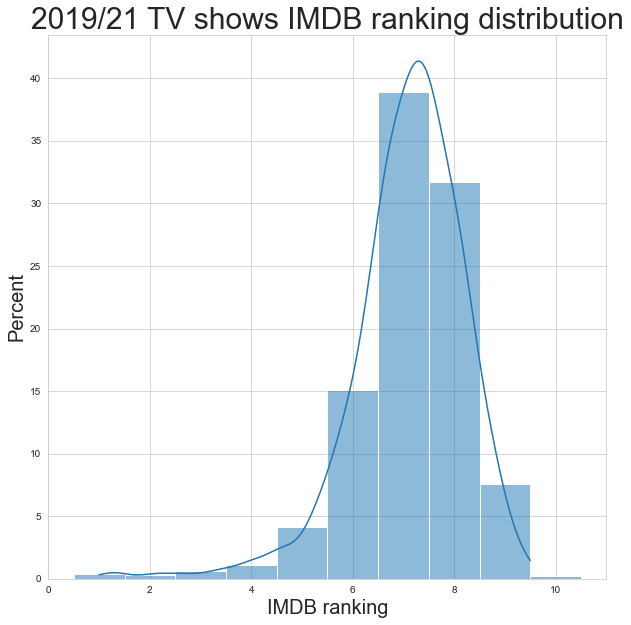

In [299]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.histplot(df.imdb_rating, stat="percent", discrete=True, kde=True)
plt.title('2019/21 TV shows IMDB ranking distribution',  fontsize = 30)
plt.ylabel('Percent', fontsize = 20)
plt.xlabel('IMDB ranking', fontsize = 20)
plt.savefig('imdb_hist_plot', bbox_inches = 'tight');

In [300]:
x = df.corr().iloc[:,0]#checking correlations between taget and features
x = list(x[abs(x)>0.05].index)
x

['imdb_rating',
 'avg_runtime',
 'Biography',
 'Musical',
 'History',
 'Reality_TV',
 'Horror',
 'News',
 'Short',
 'Sport',
 'Game_Show',
 'Sci_Fi',
 'TV_PG',
 'made_in_usa',
 'stars_a_n',
 'awards_n']

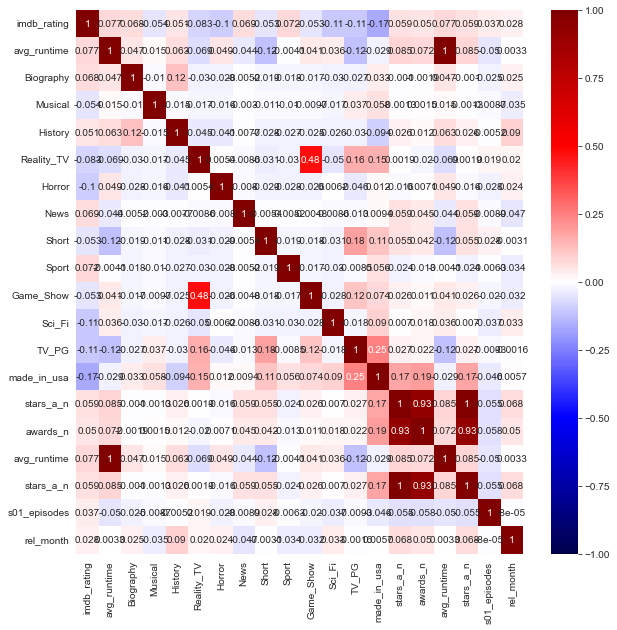

In [301]:
plt.figure(figsize = [10,10])
sns.heatmap(df[x + ['avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.savefig('imdb_heat_map', bbox_inches = 'tight');

<Figure size 720x720 with 0 Axes>

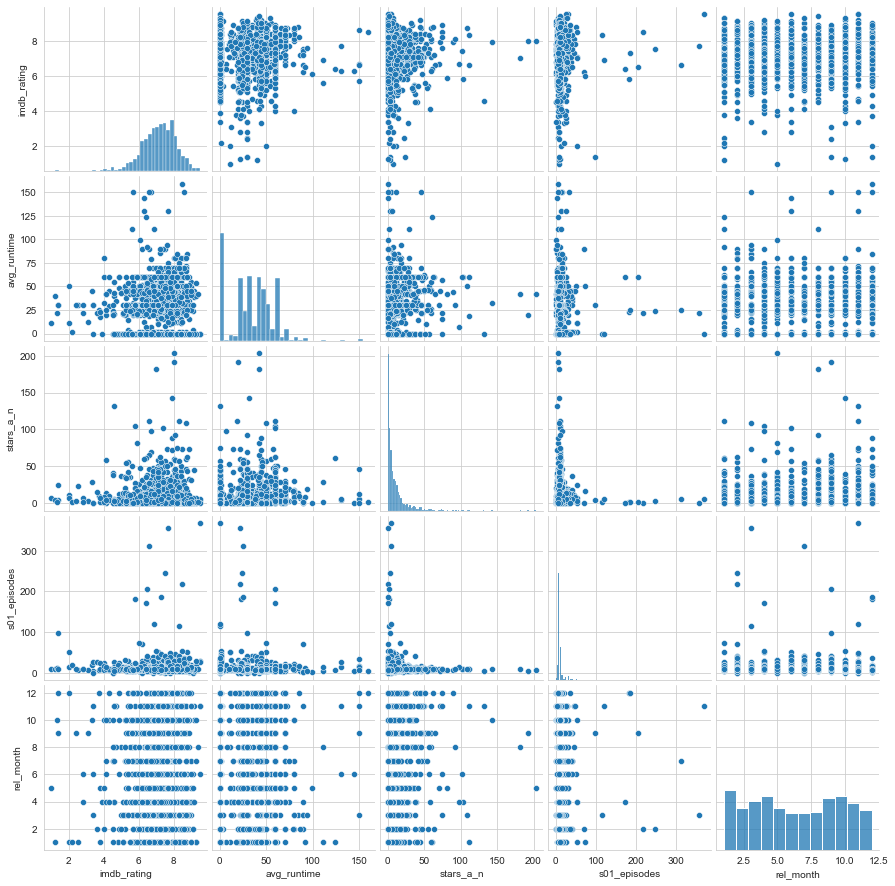

In [302]:
plt.figure(figsize = [10,10])
sns.pairplot(df[['imdb_rating', 'avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']])
plt.savefig('imdb_pair_plot', bbox_inches = 'tight');

<AxesSubplot:xlabel='s01_episodes'>

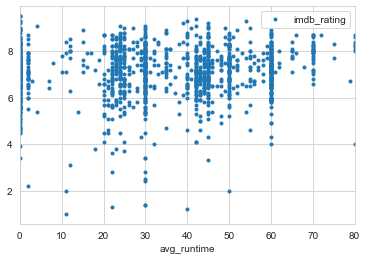

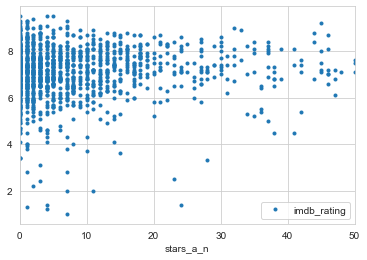

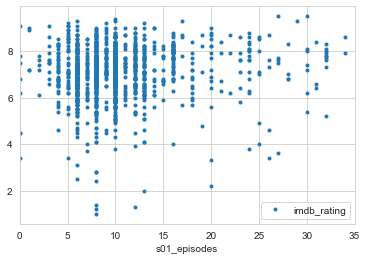

In [303]:
df.plot(x='avg_runtime',y='imdb_rating',style='.', xlim=(0,80))
df.plot(x='stars_a_n',y='imdb_rating',style='.', xlim=(0,50))
df.plot(x='s01_episodes',y='imdb_rating',style='.', xlim=(0,35))

In [304]:
#experiments with features
#df['real_game'] = ((df['made_in_usa'] == 1)&(df['TV_PG'] == 1)).apply(int)
#df['US_PG'] = ((df['made_in_usa'] == 1)&(df['TV_PG'] == 1)).apply(int)
#df['US_horror'] = ((df['made_in_usa'] == 1)&(df['Horror'] == 1)).apply(int)
#df['US_scifi'] = ((df['made_in_usa'] == 1)&(df['Sci_Fi'] == 1)).apply(int)
#df['long_stars'] = (df['avg_runtime']*df['stars_a_n']).apply(int)

In [305]:
df

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,company,...,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c,company_n,creators_a_n,stars_a_n,awards_n
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,"[Smart Dog Media, Fox Alternative Entertainmen...",...,1,1,0,0,1,0,3,0,9,9
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[Caracol],...,1,0,1,0,0,0,1,0,0,0
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,"[Netflix, The Jackal Group]",...,1,1,0,0,1,1,2,1,1,2
3,https://www.imdb.com/title/tt8324422,8.1,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Awesomeness TV, Odenkirk Provissiero Entertai...",...,2,0,0,1,1,0,3,6,7,13
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,0,Australia,[Playmaker Media],...,1,0,0,0,0,0,1,5,12,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,https://www.imdb.com/title/tt16385150,8.9,Shark Tank India,36,0,[Reality-TV],2021-12-20,0,India,[],...,12,0,0,0,0,0,0,0,0,0
1351,https://www.imdb.com/title/tt16477402,8.2,WWII in Color: Road to Victory,10,50,"[Documentary, History, War]",2021-12-22,0,United Kingdom,[],...,12,0,0,0,0,0,0,0,0,0
1352,https://www.imdb.com/title/tt11570202,6.9,The Silent Sea,8,45,"[Adventure, Drama, Mystery]",2021-12-24,TV-MA,South Korea,[Artist Studio],...,12,0,0,1,0,0,1,0,13,13
1353,https://www.imdb.com/title/tt13668894,7.3,The Book of Boba Fett,7,38,"[Action, Adventure, Sci-Fi]",2021-12-29,TV-14,United States,"[Golem Creations, Lucasfilm]",...,12,0,1,0,1,0,2,11,5,16


# REGRESSION MODEL

In [306]:
#y, X = patsy.dmatrices('imdb_rating ~  s01_episodes + avg_runtime + Horror + Romance + Short + Crime + Game_Show + Sport + Documentary + Biography + Musical + Western + Reality_TV + History + Family + Sci_Fi + Thriller+ Animation + News + TV_PG + TV_MA + made_in_usa + stars_a_n + awards_n + big_c', data=df, return_type="dataframe")
y = df.imdb_rating
X = df.drop(columns=['imdb_rating', 'link', 'title', 'genres', 'rel_date', 'certification', 'origin', 'creators', 'stars', 'creators_a', 'stars_a', 'company'], axis=1)
X = sm.add_constant(X).astype(float)

STANDARD SCALER

In [307]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in ['s01_episodes', 'avg_runtime','creators_a_n', 'stars_a_n', 'awards_n']:
    X[i] = pd.DataFrame(scaler.fit_transform(X[[i]]), columns=[i])

DATA SPIT FOR TESTING

In [308]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# As there is relatively not a lot of data points, I hold out 25% of the data for final testing, I could proceed with K fold but to keep it simple I stay with that solution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=10)

INITIAL MODEL

In [309]:
model = sm.OLS(y_train, X_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     3.592
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           9.13e-12
Time:                        22:56:04   Log-Likelihood:                -1515.3
No. Observations:                1016   AIC:                             3107.
Df Residuals:                     978   BIC:                             3294.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.0789      0.151     46.814      0.000       6.782       7.376
s01_episodes     0.0635      0.033      1.929      0.054      -0.001       0.128
avg_runtime      0.1145      0.038      2.978      0.003       0.039       0.190
Biography        0.3157      0.272      1.163      0.245      -0.217       0.849
Musical         -0.9316      0.440     -2.119      0.034      -1.794      -0.069
Action          -0.2839      0.126     -2.260      0.024      -0.530      -0.037
Animation        0.2527      0.142      1.781      0.075      -0.026       0.531
Romance          0.0237      0.123      0.193      0.847      -0.217       0.264
History         -0.0627      0.212     -0.295      0.768      -0.480       0.354
Family          -0.2631      0.253     -1.041      0.298      -0.759       0.233
Mystery         -0.1717      0.126     -1.366      0.172      -0.418       0.075
Comedy           0.0145      0.101      0.143      0.886      -0.184       0.213
Music           -0.0180      0.249     -0.072      0.942      -0.507       0.471
Reality_TV      -0.0482      0.202     -0.239      0.811      -0.444       0.348
Fantasy         -0.0807      0.150     -0.538      0.591      -0.375       0.214
Western          1.0343      0.756      1.368      0.172      -0.449       2.518
Horror          -0.6007      0.200     -3.003      0.003      -0.993      -0.208
War             -0.1550      0.415     -0.373      0.709      -0.970       0.660
Adventure        0.0512      0.144      0.354      0.723      -0.232       0.335
Crime            0.0479      0.109      0.442      0.659      -0.165       0.261
Thriller        -0.0873      0.126     -0.694      0.488      -0.334       0.160
News             3.1249      1.178      2.652      0.008       0.812       5.437
Documentary      0.1100      0.171      0.642      0.521      -0.226       0.446
Drama           -0.0911      0.102     -0.894      0.372      -0.291       0.109
Short           -0.2433      0.253     -0.961      0.337      -0.740       0.254
Talk_Show       -1.5779      0.507     -3.111      0.002      -2.573      -0.583
Sport            0.5228      0.260      2.010      0.045       0.012       1.033
Game_Show       -0.2310      0.343     -0.673      0.501      -0.905       0.443
Sci_Fi          -0.5131      0.169     -3.028      0.003      -0.846      -0.181
genres_n         0.1382      0.075      1.837      0.066      -0.009       0.286
rel_month        0.0035      0.010      0.351      0.725      -0.016       0.023
TV_PG           -0.3883      0.153     -2.536      0.011      -0.689      -0.088
TV_14           -0.1313      0.110     -1.189      0.235      -0.348       0.085
TV_MA           -0.1162      0.102     -1.143      0.253      -0.316       0.083
made_in_usa     -0.4223      0.092     -4.602      0.000      -0.602      -0.242
big_c

OLS model after selecting features with P<=0.05

In [310]:
drop_col = ['creators_a_n', 'awards_n', 'genres_n', 'company_n', 'Crime','Fantasy','Musical','Biography', 'Western', 'Comedy','TV_14','TV_MA', 'Drama','Documentary', 'rel_month', 'Short', 'big_c', 'Adventure', 'Thriller', 's01_episodes', 'War', 'Reality_TV', 'Mystery', 'Action', 'Romance', 'Game_Show', 'Family', 'Music', 'History']

#y = df.imdb_rating
#X = X.drop(columns=drop_col, axis=1)

model = sm.OLS(y_train, X_train.drop(columns=drop_col, axis=1))

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     10.71
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           2.01e-17
Time:                        22:56:04   Log-Likelihood:                -1528.6
No. Observations:                1016   AIC:                             3079.
Df Residuals:                    1005   BIC:                             3133.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2880      0.047    155.646      0.000       7.196       7.380
avg_runtime     0.1136      0.037      3.107      0.002       0.042       0.185
Animation       0.2464      0.105      2.350      0.019       0.041       0.452
Horror         -0.5847      0.190     -3.084      0.002      -0.957      -0.213
News            3.1120      1.206      2.580      0.010       0.745       5.479
Talk_Show      -1.3391      0.492     -2.722      0.007      -2.305      -0.374
Sport           0.6547      0.255      2.568      0.010       0.154       1.155
Sci_Fi         -0.4742      0.164     -2.897      0.004      -0.795      -0.153
TV_PG          -0.3017      0.119     -2.531      0.012      -0.536      -0.068
made_in_usa    -0.4358      0.075     -5.839      0.000      -0.582      -0.289
stars_a_n       0.1002      0.035      2.887      0.004       0.032       0.168
==============================================================================
Omnibus:                      314.346   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1310.464
Skew:                          -1.408   Prob(JB):                    2.73e-285
Kurtosis:                       7.799   Cond. No.                         39.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TEST

In [311]:
lr=LinearRegression()
lr.fit(X_train.drop(columns=drop_col+['const'], axis=1), y_train)

LinearRegression()

In [312]:
lr.score(X_train.drop(columns=drop_col+['const'], axis=1), y_train)

0.09629376679646173

In [313]:
lr.score(X.drop(columns=drop_col+['const'], axis=1), y)

0.07219823440024142

coefficient of determination: 0.09629376679646173
      Actual  Predicted
1123     6.9   7.075081
593      9.0   7.205924
1182     7.6   7.132735
102      2.8   7.210521
872      6.6   7.402774
...      ...        ...
450      7.9   6.298958
905      8.1   7.432027
968      6.0   7.316215
194      6.7   6.848612
52       6.4   6.964667

[339 rows x 2 columns]


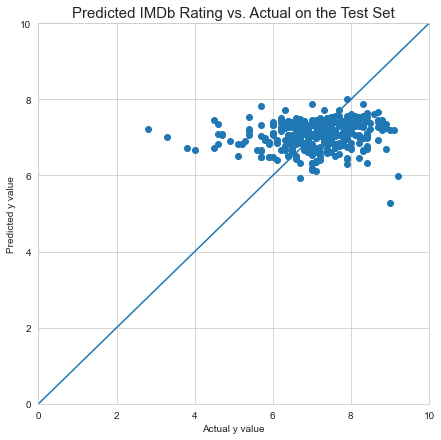

In [314]:
%matplotlib inline



r_sq = lr.score(X_train.drop(columns=drop_col+['const'], axis=1), y_train)
print('coefficient of determination:', r_sq)

y_pred = lr.predict(X_test.drop(columns=drop_col+['const']))

df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df2)

plt.figure(figsize=(7,7))
plt.title('Predicted IMDb Rating vs. Actual on the Test Set', fontsize=15)
plt.ylim(0,10)
plt.xlim(0,10)
plt.xlabel('Actual y value')
plt.ylabel('Predicted y value')
plt.scatter(y_test, y_pred)
plt.plot(range(11), range(11))
plt.savefig('KDE Plot of IMDb Rating', bbox_inches = 'tight');



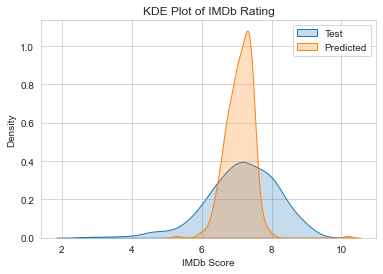

In [315]:
sns.kdeplot(y_test, shade=True)
sns.kdeplot(y_pred, shade=True)
plt.title('KDE Plot of IMDb Rating')
plt.xlabel('IMDb Score')
plt.ylabel('Density')
plt.legend(['Test','Predicted'])
plt.savefig('KDE Plot of IMDb Rating', bbox_inches = 'tight');

# LASSO MODEL

LASSOCV

In [316]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [317]:
## Scaling the data
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [318]:
## Scaling the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [319]:
# Running the cross validation, finding the best alpha, refitting the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [320]:
# This is the best alpha value it found 
lasso_model.alpha_

0.0419870708444391

In [321]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))



[('const', 0.0),
 ('s01_episodes', 0.008448621138328151),
 ('avg_runtime', 0.06113788684910346),
 ('Biography', 0.017519831239328255),
 ('Musical', -0.018970983166913133),
 ('Action', -0.0),
 ('Animation', 0.02962088407609874),
 ('Romance', 0.0019122433193175525),
 ('History', 0.0),
 ('Family', -0.0),
 ('Mystery', -0.0),
 ('Comedy', 0.0),
 ('Music', 0.0),
 ('Reality_TV', -0.0),
 ('Fantasy', -0.0),
 ('Western', 0.007675469389197356),
 ('Horror', -0.06631332653767226),
 ('War', -0.0),
 ('Adventure', 0.0),
 ('Crime', 0.0),
 ('Thriller', 0.0),
 ('News', 0.02950295463450403),
 ('Documentary', 0.0),
 ('Drama', 0.0),
 ('Short', -0.0),
 ('Talk_Show', -0.03233327406793979),
 ('Sport', 0.04429893429145557),
 ('Game_Show', -0.0),
 ('Sci_Fi', -0.06372877000287977),
 ('genres_n', 0.006625217930443653),
 ('rel_month', 0.0),
 ('TV_PG', -0.050547237764353915),
 ('TV_14', -0.0),
 ('TV_MA', -0.0),
 ('made_in_usa', -0.1738396080030639),
 ('big_c', 0.0),
 ('company_n', 0.0),
 ('creators_a_n', 0.0),
 ('sta

In [322]:
# Predictions at the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [323]:
# Finding the MAE and R^2 on the test set using this model
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.7822945143675373

In [324]:
r2_score(y_test, test_set_pred)

0.02779805214720743

LARS PATH - TO STUDY FEATURE IMPORTANCE

In [325]:
from sklearn.linear_model import lars_path

In [326]:
## Scale the variables
std = StandardScaler()
std.fit(X_train.values)


StandardScaler()

In [327]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


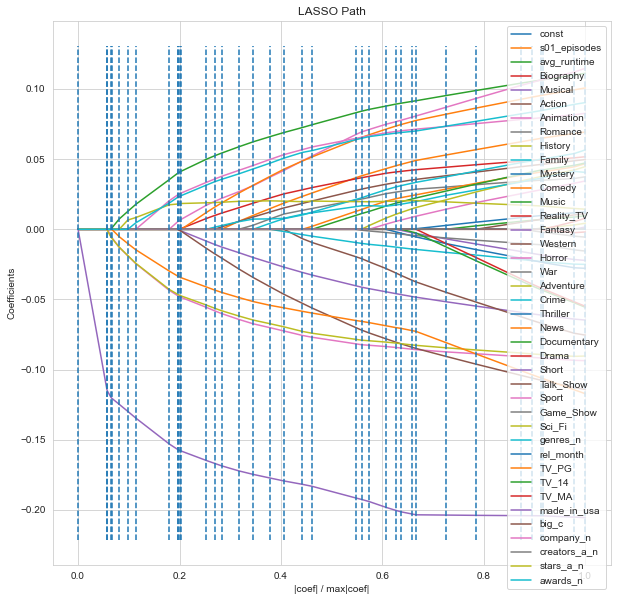

<Figure size 432x288 with 0 Axes>

In [328]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))

plt.plot(xx, coefs.T)

ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)

plt.show()
plt.savefig('LASSO Path', bbox_inches = 'tight');

# RIDGE MODEL

RIDGECV

In [329]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [330]:
## Scaling the data
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [331]:
## Scaling the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [332]:
# Running the cross validation, finding the best alpha, refitting the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [333]:
# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [334]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
pd.DataFrame(list(zip(X_train.columns, ridge_model.coef_))).columns

RangeIndex(start=0, stop=2, step=1)

In [335]:
# Predictions at the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [336]:
# Finding the MAE and R^2 on the test set using this model
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.7812400936123753

In [337]:
r2_score(y_test, test_set_pred)

-0.003771067145760032